## Libraries

In [1]:
library(ggplot2)
library(dplyr)
library(ggpubr)
library(tidyr)
library(ggsci)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load data

In [2]:
spl.res<-readRDS("../input/tcga.condition.res.lfcShrink.RDS")
gex.res<-readRDS("../input/tcga.condition.gex.res.lfcShrink.RDS")
load("../input/tcga.metadata.RData",verbose = T)

Loading objects:
  metadata


In [3]:
spl.res <- spl.res %>%
            mutate(exp_var = case_when(exp_var=="conditiontumor" ~ "condition",
                                       exp_var=="sex1" ~ "sex",
                                      TRUE ~ exp_var))

In [4]:
tcga.colors<-c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548",
               "#B71C1C")
names(tcga.colors)<-sort(unique(metadata$cancer))

#### Number of significant events vs number of samples 
- Number of significant events with condition/impurity vs the number of tumor or normal samples

In [5]:
nsamples<-metadata %>%
          filter(!is_outlier.lof&condition=="tumor" | condition=="normal") %>%
          group_by(cancer,condition) %>%
          summarize(num_samples = length(file_id)) %>%
          mutate(total = sum(num_samples),
                 prop_samples = num_samples/total)

`summarise()` has grouped output by 'cancer'. You can override using the
`.groups` argument.


In [6]:
nevents<-spl.res %>%
         mutate(padj=ifelse(is.na(padj),1,padj)) %>%
         group_by(event_type,cancer,exp_var) %>%
         summarize(nsig_events=sum(padj<0.05),
                   total_events=length(padj),
                   prop_events=nsig_events/total_events)

`summarise()` has grouped output by 'event_type', 'cancer'. You can override
using the `.groups` argument.


In [7]:
head(nevents)

event_type,cancer,exp_var,nsig_events,total_events,prop_events
<chr>,<chr>,<chr>,<int>,<int>,<dbl>
A3,BLCA,age,408,16177,0.025220993
A3,BLCA,condition,869,16177,0.053718242
A3,BLCA,impurity,3266,16177,0.201891574
A3,BLCA,sex,71,16177,0.004388947
A3,BRCA,age,368,16723,0.022005621
A3,BRCA,condition,4779,16723,0.285774084


Joining, by = "cancer"


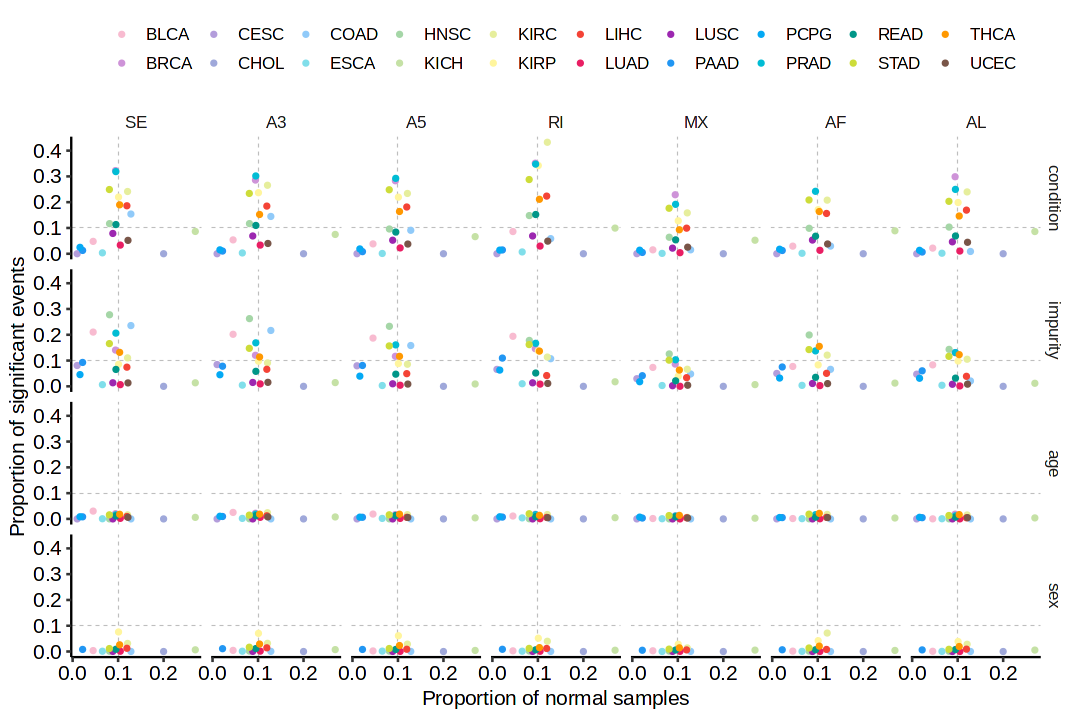

In [9]:
options(repr.plot.width=9,repr.plot.height=6)
pdata<-left_join(nevents,nsamples) %>%
        filter(condition=="normal") %>%
        mutate(exp_var=factor(exp_var,levels=c("condition","impurity","age","sex")),
               event_type = factor(event_type,levels=c("SE","A3","A5","RI","MX","AF","AL")))
cond.colors<-tcga.colors[unique(pdata$cancer)]

g<-ggplot(pdata,aes(x=prop_samples,y=prop_events,color=cancer))+
    geom_hline(yintercept = 0.1,linetype="dashed",color="grey",linewidth=0.25)+
    geom_vline(xintercept = 0.1,linetype="dashed",color="grey",linewidth=0.25)+
    geom_point(size=1)+
    facet_grid(~exp_var~event_type)+
    scale_color_manual(values = cond.colors)+
    theme_pubr()+
    theme(strip.background=element_blank())+
    guides(color=guide_legend(nrow=2))+
    labs(x="Proportion of normal samples",y="Proportion of significant events",color="")
ggsave(g,filename = "../output/figures/biases/normal_samples_to_sig_events.pdf",width=9,height=6,device="pdf",units="in")
g

#### Mean lfc of all events in the same gene vs gene lfc in tumor vs normal 

In [10]:
avg.spl<-spl.res %>%
         filter(exp_var=="condition")%>%
         group_by(cancer,gene_id,event_type) %>%
         summarize(mean_log2FoldChange = mean(log2FoldChange,na.rm=T),
                    nevents_in_gene = length(log2FoldChange),
                    sd_log2FoldChange = sd(log2FoldChange,na.rm=T))

`summarise()` has grouped output by 'cancer', 'gene_id'. You can override using
the `.groups` argument.


In [11]:
cond<-gex.res %>%
        filter(exp_var=="condition_tumor_vs_normal") %>%
        select(cancer,gene_id,log2FoldChange,padj) %>%
        inner_join(.,avg.spl,) 
head(cond)

Joining, by = c("cancer", "gene_id")


,cancer,gene_id,log2FoldChange,padj,event_type,mean_log2FoldChange,nevents_in_gene,sd_log2FoldChange
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<dbl>
1,BLCA,ENSG00000000003.15,1.2955584,5.530894e-06,A5,0.0265470,2,0.3240671
2,BLCA,ENSG00000000003.15,1.2955584,5.530894e-06,AF,0.1975281,1,NA
3,BLCA,ENSG00000000003.15,1.2955584,5.530894e-06,SE,-0.1092400,1,NA
4,BLCA,ENSG00000000419.13,0.3657051,2.103470e-02,A3,0.2687549,2,0.7737880
5,BLCA,ENSG00000000419.13,0.3657051,2.103470e-02,A5,0.1684758,1,NA
6,BLCA,ENSG00000000419.13,0.3657051,2.103470e-02,MX,-1.1524255,1,NA


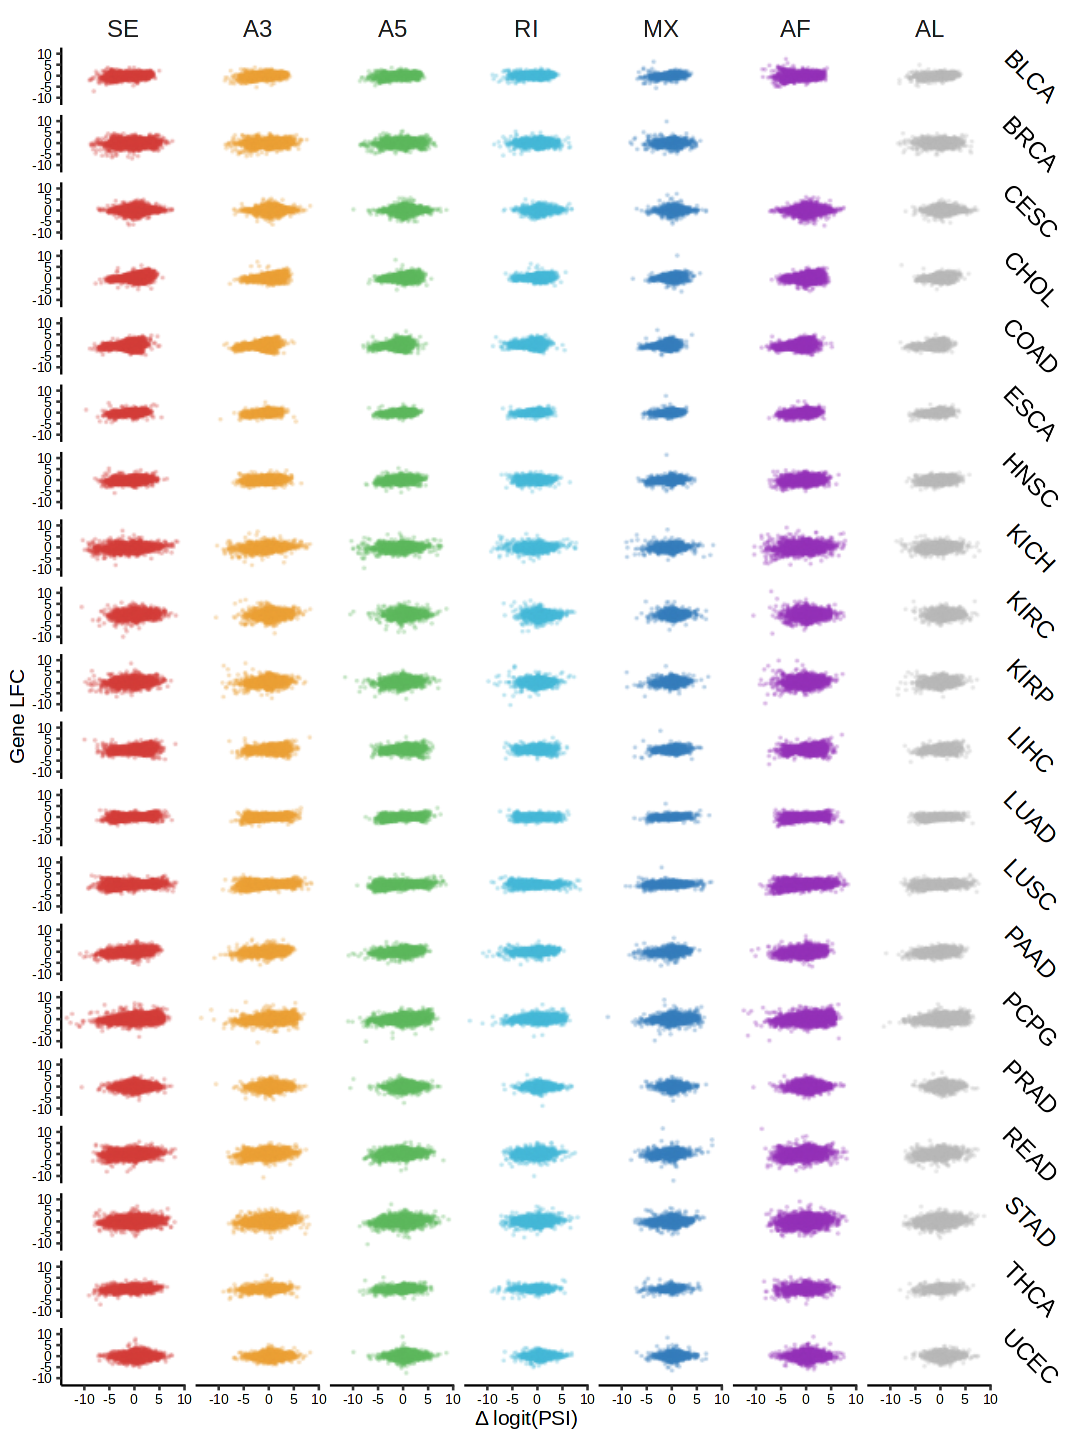

In [12]:
options(repr.plot.width=9,repr.plot.height=12)
g<-cond %>%
    mutate(event_type = factor(event_type,levels=c("SE","A3","A5","RI","MX","AF","AL"))) %>%
    ggplot(.,aes(x=log2FoldChange,mean_log2FoldChange,color=event_type))+
        ggrastr::rasterise(geom_point(size=0.05,alpha=0.25))+
        facet_grid(~cancer~event_type)+
        theme_pubr()+
        theme(strip.background=element_blank(),
              legend.position="none",
              axis.text = element_text(size=8),
              strip.text=element_text(size=14),
              strip.text.y=element_text(angle=-45,color="black"))+
        labs(x='\u0394 logit(PSI)',y='Gene LFC')+
        scale_color_locuszoom()+
        guides(color=guide_legend(nrow=1))
g
ggsave(g,filename="../output/figures/biases/dpsi_vs_dge.pdf",width = 9,height = 12,device=cairo_pdf,units="in")

In [13]:
cond.sum <- cond %>%
             group_by(event_type,cancer) %>%
             summarize(nevents=sum(nevents_in_gene),
                       ngenes=length(unique(gene_id)),
                       cors=list(cor.test(log2FoldChange,mean_log2FoldChange))) %>%
             mutate(ci_low = unlist(lapply(cors,function(cr){cr$conf.int[1]})),
                    ci_high = unlist(lapply(cors,function(cr){cr$conf.int[2]})),
                    coef = unlist(lapply(cors,function(cr){cr$estimate})),
                    pvalue = unlist(lapply(cors,function(cr){cr$p.value})))

`summarise()` has grouped output by 'event_type'. You can override using the
`.groups` argument.


In [14]:
cord<-cond.sum %>%
        group_by(cancer) %>%
        summarize(mc=mean(coef)) %>%
        arrange(desc(mc))

In [15]:
mean(cond.sum$coef)

[1] 0.1592701

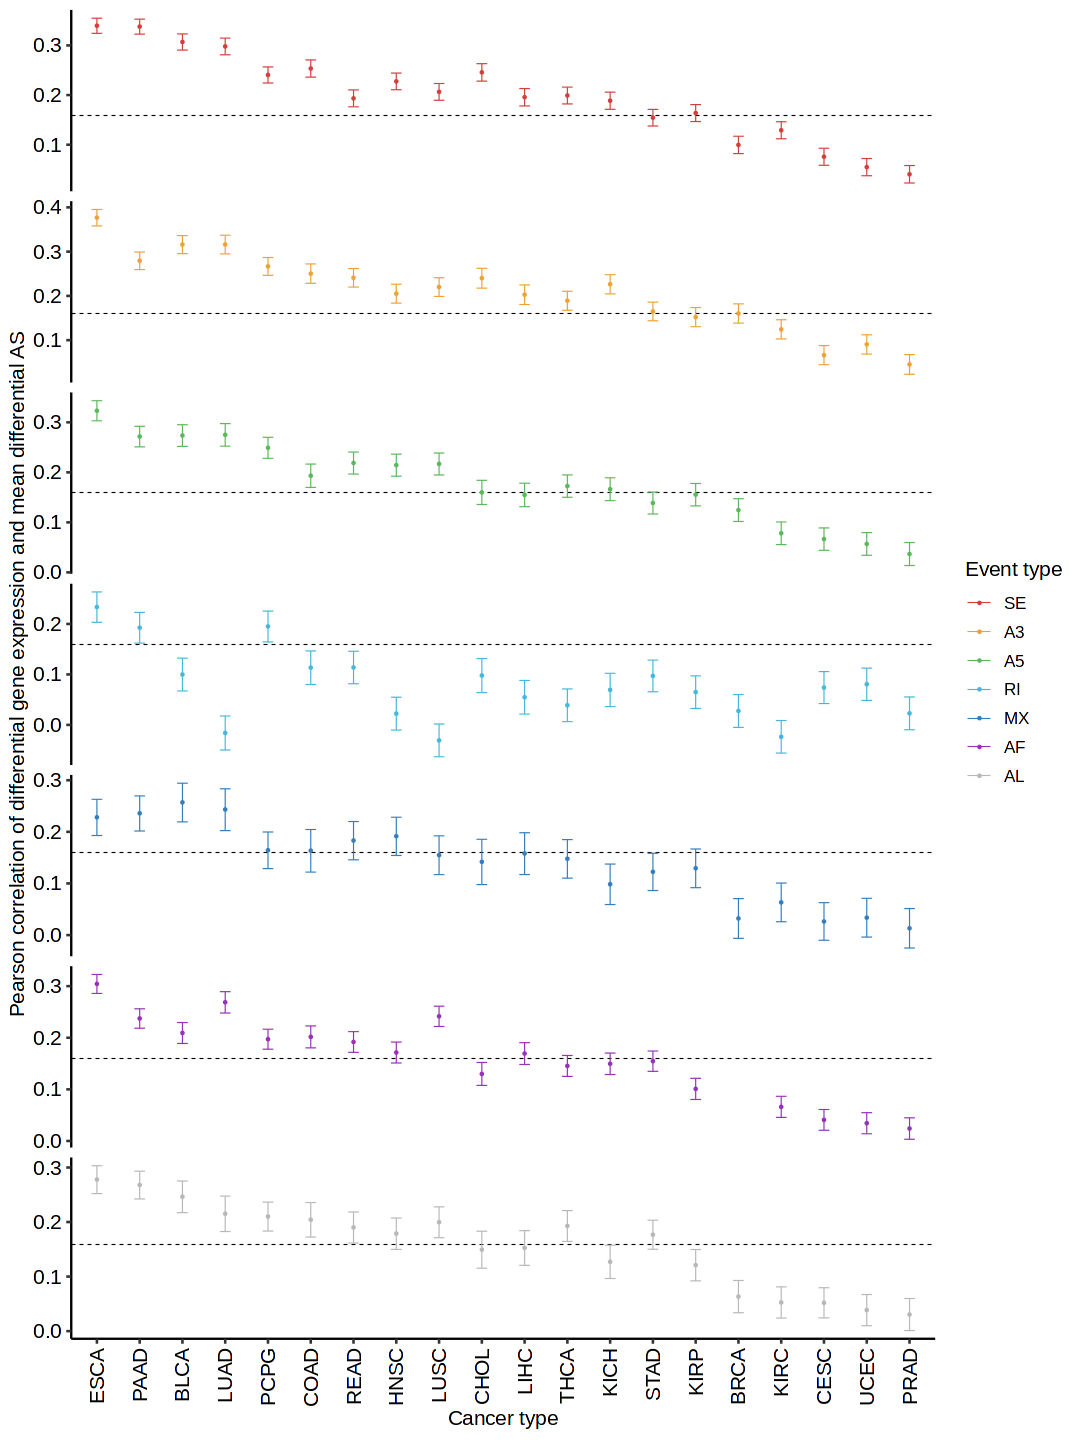

In [16]:
g<-cond.sum %>%
    mutate(event_type = factor(event_type,levels=c("SE","A3","A5","RI","MX","AF","AL")),
           cancer = factor(cancer,levels=cord$cancer)) %>%
    ggplot(.,aes(x=cancer,y=coef,color=event_type))+
        geom_hline(yintercept = mean(cond.sum$coef),linetype="dashed",linewidth=0.25)+
        geom_point(size=0.25)+
        geom_errorbar(aes(ymin=ci_low,ymax=ci_high),linewidth=0.25,width=0.25)+
        scale_color_locuszoom()+
        theme_pubr()+
        facet_wrap(~event_type,ncol=1,scales="free_y")+
        labs(y="Pearson correlation of differential gene expression and mean differential AS",
             color="Event type",
             x="Cancer type")+
        theme(legend.position="right",
              strip.background=element_blank(),
              strip.text=element_blank(),
              axis.text.x=element_text(angle=90,hjust=1,vjust=0.5))
ggsave(g,filename="../output/figures/biases/dpsi_vs_dge_correlations.pdf",width = 7,height = 9,device=cairo_pdf,units="in")
g

In [17]:
ggsave(g,filename="../output/figures/biases/dpsi_vs_dge_correlations.png",width = 7,height = 9,device="png",dpi=800,units="in")

In [18]:
cors<-cond.sum %>%
        select(-cors) %>%
        arrange(cancer)
write.table(cors,file = "../output/tables/correlations.dLogitPSI.dgeLFC.tsv",quote=F,sep="\t",row.names = FALSE)